<a target="_blank" href="https://colab.research.google.com/drive/1umIpFVnuYQxKad7cIh5knMXA7MZJBfSM?usp=sharing">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pwd
%cd /content/drive/MyDrive/Colab\ Notebooks/Optimizing-EDM-and-LA-to-Enhance-Equity-for-Underrepresented-Students
# Install required packages
!pip install fairlearn
!pip install --upgrade category_encoders
!pip install lime scikit-learn --upgrade
!pip install aif360

/content
/content/drive/MyDrive/Colab Notebooks/Optimizing-EDM-and-LA-to-Enhance-Equity-for-Underrepresented-Students
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.3/232.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=bdd2a0757ea52e2d6f5f1db2d0e0905657c1322eb935cbd950d7dffb511b800a
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 4.3 MB/s eta 0:00:00


In [3]:
# Section 1: Setup and Configuration
# ----------------------------------
# Import necessary libraries and packages
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
from fairlearn.metrics import MetricFrame, demographic_parity_difference, equalized_odds_difference
from fairlearn.reductions import ExponentiatedGradient, DemographicParity, EqualizedOdds


In [4]:
# Section 2: Data Preparation
# ---------------------------
# Load and map the data
data = pd.read_csv("data/student_dropout.csv")
marital_status_mapping = {1: 'Single', 2: 'Married', 3: 'Widower', 4: 'Divorced', 5: 'Facto union', 6: 'Legally separated'}
gender_mapping = {1: 'Male', 0: 'Female'}
yes_no_mapping = {1: 'Yes', 0: 'No'}
data_mapped = data.copy()
data_mapped['Marital status'] = data_mapped['Marital status'].replace(marital_status_mapping)
data_mapped['Gender'] = data_mapped['Gender'].replace(gender_mapping)
for col in ['Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Scholarship holder', 'International']:
    data_mapped[col] = data_mapped[col].replace(yes_no_mapping)


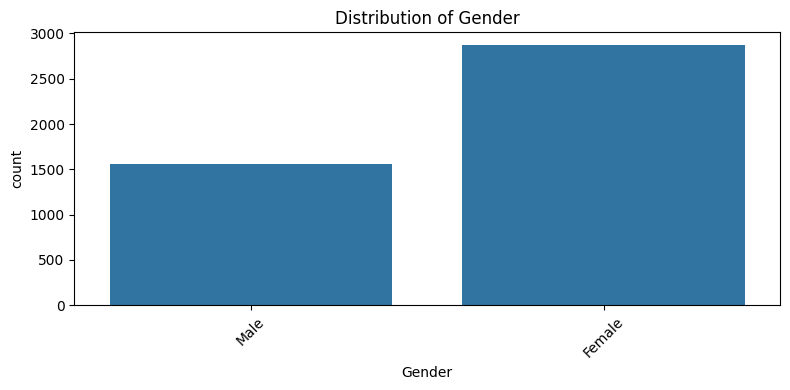

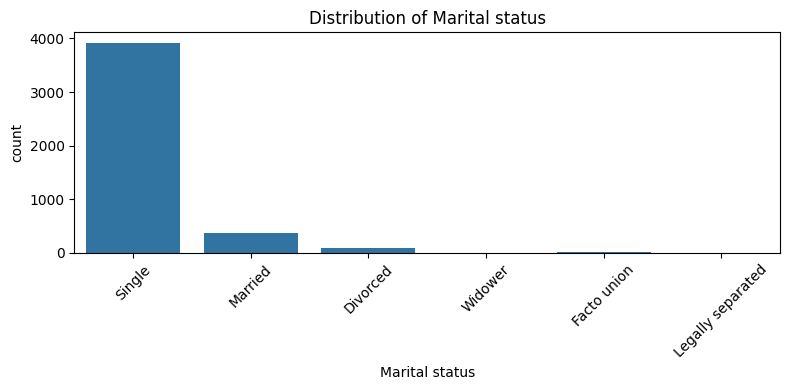

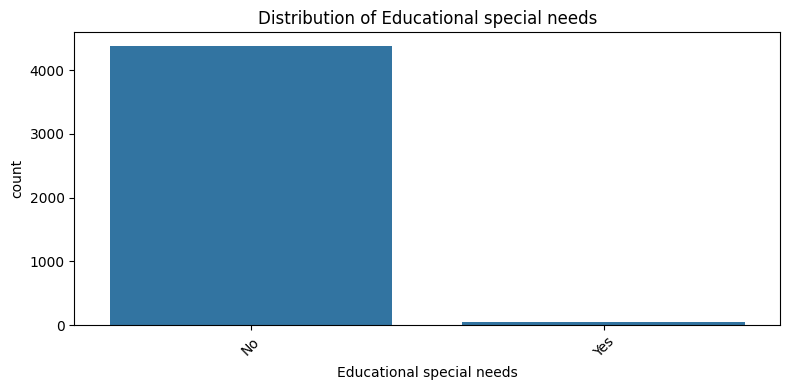

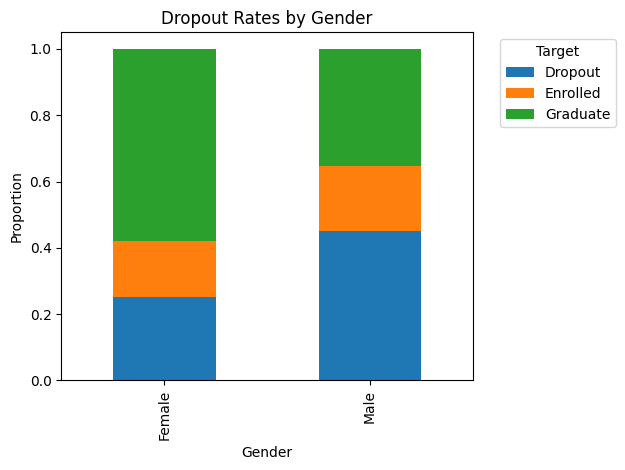

In [5]:
# Section 3: Exploratory Data Analysis (EDA)
# ------------------------------------------
def perform_eda(mapped_data):
    for col in ['Gender', 'Marital status', 'Educational special needs']:
        plt.figure(figsize=(8, 4))
        sns.countplot(x=col, data=mapped_data)
        plt.title(f'Distribution of {col}')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    dropout_by_gender = mapped_data.groupby('Gender')['Target'].value_counts(normalize=True).unstack()
    dropout_by_gender.plot(kind='bar', stacked=True)
    plt.title('Dropout Rates by Gender')
    plt.ylabel('Proportion')
    plt.legend(title='Target', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

perform_eda(data_mapped)


In [6]:
# Section 4: Preprocessing Pipeline Setup
# ---------------------------------------
X = data.drop(['Target'], axis=1)
y = (data['Target'] == 'Dropout').astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)


In [7]:
# Section 5: Model Building and Evaluation
# ----------------------------------------
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', random_state=42))
])
model_pipeline.fit(X_train, y_train)
y_pred = model_pipeline.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       601
           1       0.87      0.73      0.79       284

    accuracy                           0.88       885
   macro avg       0.88      0.84      0.85       885
weighted avg       0.88      0.88      0.88       885

Confusion Matrix:
[[571  30]
 [ 77 207]]


In [8]:
# Section 6: Fairness Analysis
# ----------------------------
sensitive_feature = X_test['Gender']
def compute_fairness_metrics(y_true, y_pred, sensitive_features):
    metric_frame = MetricFrame(
        metrics={'accuracy': accuracy_score, 'precision': precision_score, 'recall': recall_score, 'f1_score': f1_score},
        y_true=y_true, y_pred=y_pred, sensitive_features=sensitive_features
    )
    dp_diff = demographic_parity_difference(y_true, y_pred, sensitive_features=sensitive_features)
    eo_diff = equalized_odds_difference(y_true, y_pred, sensitive_features=sensitive_features)
    print("Fairness Metrics:")
    print(metric_frame.by_group)
    print(f"\nDemographic Parity Difference: {dp_diff:.2f}")
    print(f"Equalized Odds Difference: {eo_diff:.2f}")

compute_fairness_metrics(y_test, y_pred, sensitive_feature)
estimator = LogisticRegression(solver='liblinear', random_state=42)
mitigator = ExponentiatedGradient(estimator, constraints=DemographicParity())
mitigator.fit(X_train, y_train, sensitive_features=X_train['Gender'])
y_pred_fair = mitigator.predict(X_test)
compute_fairness_metrics(y_test, y_pred_fair, sensitive_feature)


Fairness Metrics:
        accuracy  precision    recall  f1_score
Gender                                         
0       0.900709   0.879630  0.688406  0.772358
1       0.841121   0.868217  0.767123  0.814545

Demographic Parity Difference: 0.21
Equalized Odds Difference: 0.08
Fairness Metrics:
        accuracy  precision    recall  f1_score
Gender                                         
0       0.898936   0.783217  0.811594  0.797153
1       0.791277   0.943820  0.575342  0.714894

Demographic Parity Difference: 0.02
Equalized Odds Difference: 0.24


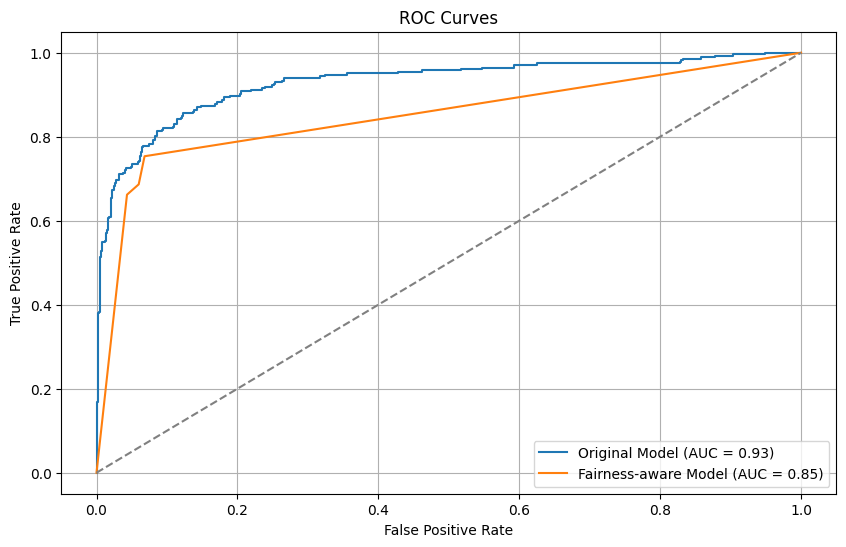

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Define the ROC curve plotting function
def plot_roc_curve(model, X_test, y_test, model_name, is_fair_model=False):
    # Obtain the probability estimates for the positive class
    y_probs = model._pmf_predict(X_test)[:, 1] if is_fair_model else model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_probs)  # Calculate FPR and TPR for the ROC
    roc_auc = auc(fpr, tpr)  # Calculate the Area Under the Curve (AUC)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')  # Plot the ROC curve for the model

# Create a figure for plotting
plt.figure(figsize=(10, 6))

# Plot ROC curves for both the original and the fairness-aware models
plot_roc_curve(model_pipeline, X_test, y_test, "Original Model", is_fair_model=False)
plot_roc_curve(mitigator, X_test, y_test, "Fairness-aware Model", is_fair_model=True)

# Plot the diagonal line indicating the no-skill classifier
plt.plot([0, 1], [0, 1], '--', color='gray')  # Corrected to remove the redundant color specification

# Set the plot title and labels
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Add a legend and grid for better readability
plt.legend(loc='lower right')
plt.grid(True)  # Enable the grid for better visualization of plot scales
plt.show()  # Display the plot


In [10]:
# Section 8: Hyperparameter Tuning
# --------------------------------
from sklearn.model_selection import GridSearchCV

param_grid = {'classifier__C': [0.01, 0.1, 1, 10], 'classifier__penalty': ['l2']}
grid_search = GridSearchCV(model_pipeline, param_grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print("Best Model Parameters:", grid_search.best_params_)

Best Model Parameters: {'classifier__C': 0.1, 'classifier__penalty': 'l2'}


In [11]:
# Section 9: Ensemble Methods
# ---------------------------
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier

preprocessor = Pipeline(steps=[('scaler', StandardScaler())])
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)
estimators = [
    ('lr', LogisticRegression(solver='saga', max_iter=1000, random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
]
stacked_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(solver='saga', max_iter=1000, random_state=42)
)
stacked_model.fit(X_train_scaled, y_train)
y_pred_stacked = stacked_model.predict(X_test_scaled)
print("Classification Report for Stacked Model:")
print(classification_report(y_test, y_pred_stacked))
print("Confusion Matrix for Stacked Model:")
print(confusion_matrix(y_test, y_pred_stacked))

Classification Report for Stacked Model:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       601
           1       0.87      0.75      0.81       284

    accuracy                           0.88       885
   macro avg       0.88      0.85      0.86       885
weighted avg       0.88      0.88      0.88       885

Confusion Matrix for Stacked Model:
[[569  32]
 [ 70 214]]


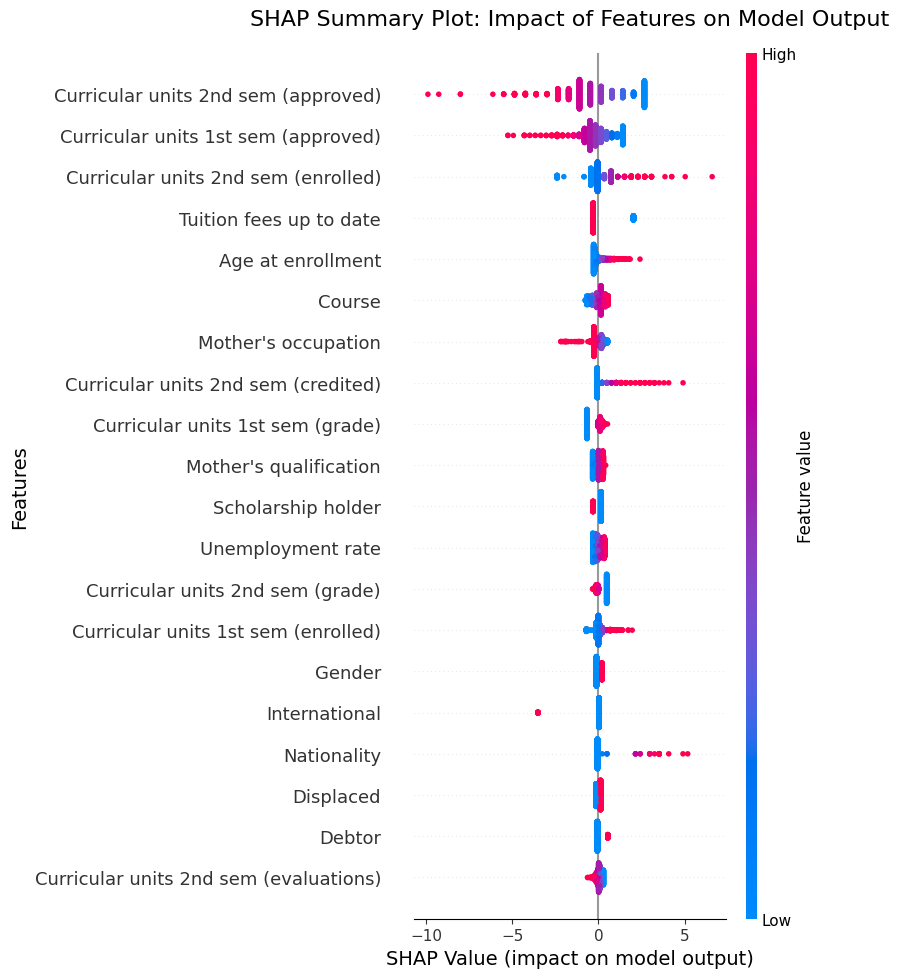

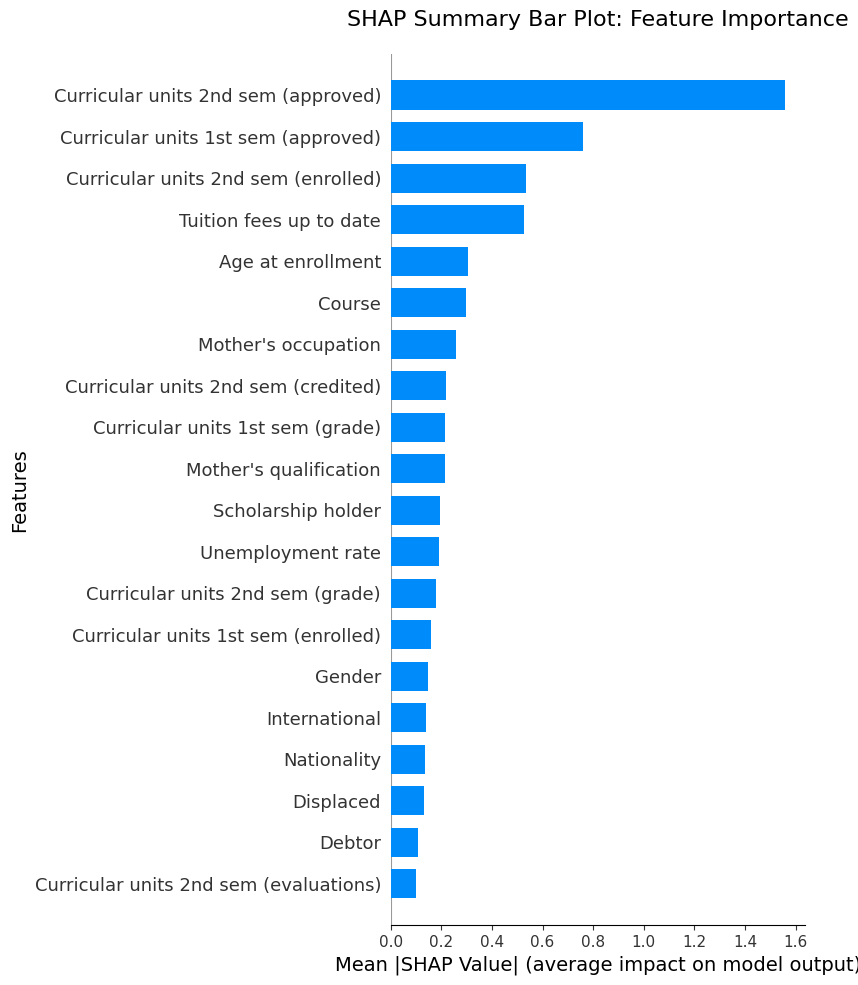

In [12]:
import matplotlib.pyplot as plt
import shap

# Create the SHAP explainer and compute SHAP values
explainer = shap.Explainer(model_pipeline.named_steps['classifier'], X_train_scaled)
shap_values = explainer(X_test_scaled)

# SHAP Summary Plot for feature impact
plt.figure(figsize=(14, 8))
shap.summary_plot(shap_values, X_test_scaled, feature_names=X_test.columns, show=False)
plt.title('SHAP Summary Plot: Impact of Features on Model Output', fontsize=16, pad=20)
plt.xlabel('SHAP Value (impact on model output)', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.show()

# SHAP Summary Bar Plot for feature importance
plt.figure(figsize=(12, 6))
shap.summary_plot(shap_values, X_test_scaled, plot_type="bar", feature_names=X_test.columns, show=False)
plt.title('SHAP Summary Bar Plot: Feature Importance', fontsize=16, pad=20)
plt.xlabel('Mean |SHAP Value| (average impact on model output)', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.show()


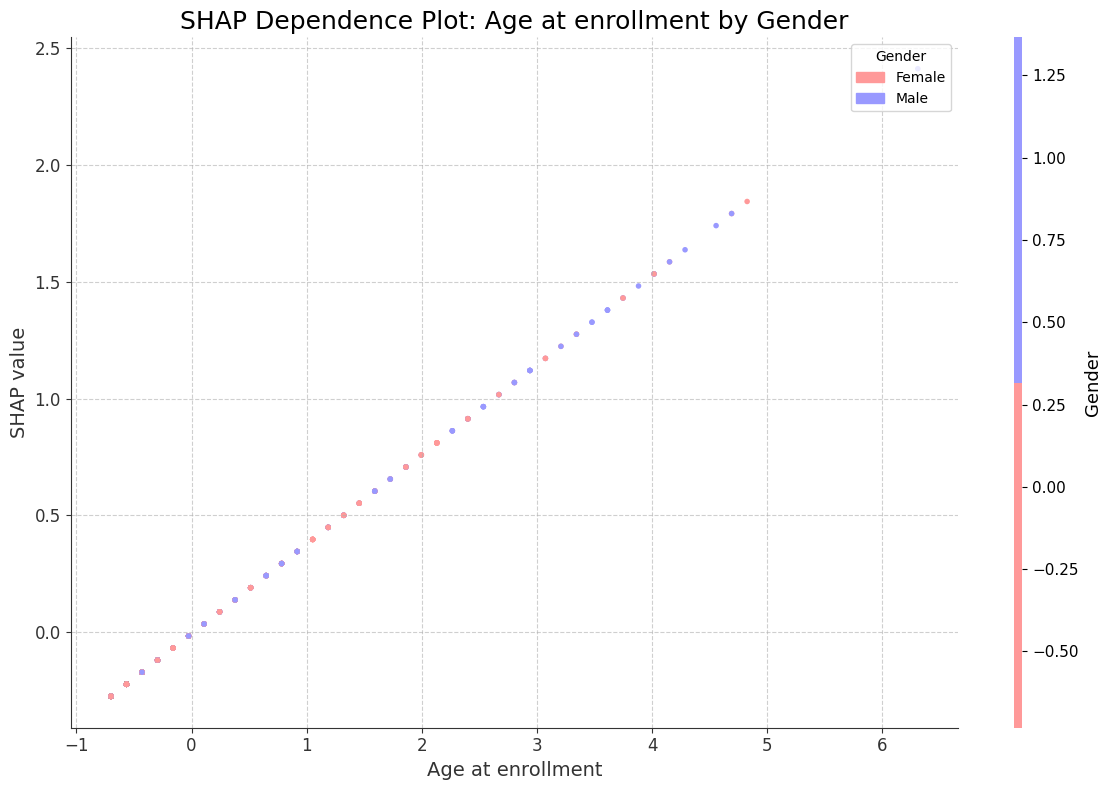

In [13]:
import matplotlib.pyplot as plt
import shap
import matplotlib.colors as mcolors

# Define a colormap for gender visualization
cmap = mcolors.ListedColormap(['#FF9999', '#9999FF'])  # Pink for female, blue for male
gender_labels = ['Female', 'Male']  # Corresponding labels for the colors

# SHAP Dependence Plot
explainer = shap.Explainer(model_pipeline.named_steps['classifier'], X_train_scaled)
shap_values = explainer(X_test_scaled)

feature_name = 'Age at enrollment'
interaction_index = 'Gender'  # 0 for female, 1 for male

if feature_name in X_test.columns:
    # Create a single subplot explicitly to control plot generation
    fig, ax = plt.subplots(figsize=(12, 8))
    # Call shap.dependence_plot
    shap.dependence_plot(
        ind=feature_name,
        shap_values=shap_values.values,
        features=X_test_scaled,
        feature_names=X_test.columns,
        interaction_index=interaction_index,
        ax=ax,
        show=False,  # Prevent automatic showing of the plot
        cmap=cmap  # Apply custom colormap
    )
    # Title and labels
    plt.title(f"SHAP Dependence Plot: {feature_name} by Gender", fontsize=18)
    ax.set_xlabel(feature_name, fontsize=14)
    ax.set_ylabel('SHAP value', fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.tick_params(axis='both', which='major', labelsize=12)

    # Create a custom legend for gender
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='#FF9999', edgecolor='#FF9999', label='Female'),
                       Patch(facecolor='#9999FF', edgecolor='#9999FF', label='Male')]
    ax.legend(handles=legend_elements, title='Gender', loc='upper right')

    # Ensure only one plot is shown
    plt.tight_layout()
    plt.show()
else:
    print(f"Feature '{feature_name}' not found in the dataset.")


Model Accuracy: 0.6463
Model Accuracy: 0.6463
Model Accuracy: 0.6463
Model Accuracy: 0.7164
Model Accuracy: 0.8542
Model Accuracy: 0.8825
Model Accuracy: 0.8554
Model Accuracy: 0.6746
Model Accuracy: 0.3537
Model Accuracy: 0.3537
Best Model Accuracy: 0.8825


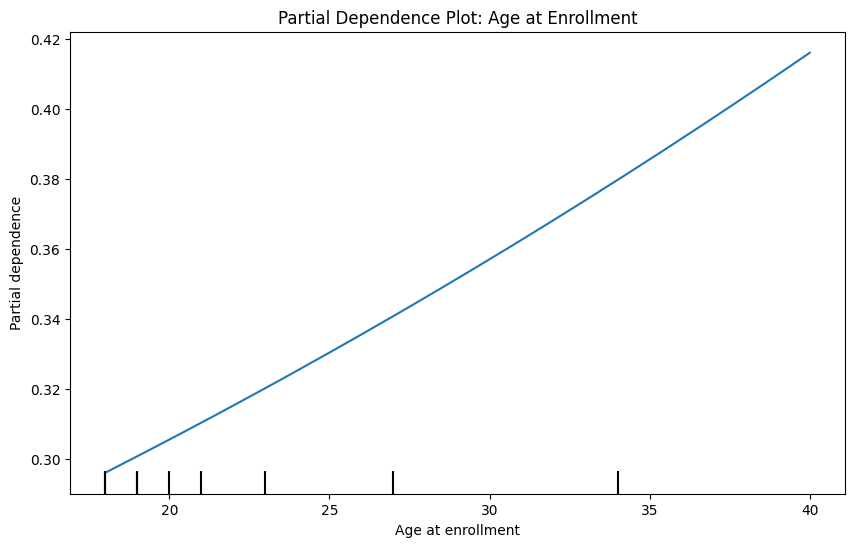

In [14]:
from fairlearn.reductions import GridSearch, DemographicParity
from sklearn.metrics import accuracy_score

# Define the fairness-aware GridSearch
fair_grid = GridSearch(estimator, constraints=DemographicParity(), grid_size=10)

# Fit the model with sensitive features
fair_grid.fit(X_train, y_train, sensitive_features=X_train['Gender'])

# Access all the results
models = fair_grid.predictors_

# Evaluate each model to find the one with the best accuracy while satisfying fairness constraints
best_accuracy = 0
best_model = None

for model in models:
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model Accuracy: {accuracy:.4f}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model

# Use the best_model for further predictions and evaluations
print(f"Best Model Accuracy: {best_accuracy:.4f}")

from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Use PartialDependenceDisplay to plot the partial dependence plot
fig, ax = plt.subplots(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(
    model_pipeline,
    X_train,
    features=['Age at enrollment'],
    grid_resolution=20,
    ax=ax
)
plt.title("Partial Dependence Plot: Age at Enrollment")
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Overall Metrics:
accuracy     0.353672
precision    0.244681
recall       0.485915
f1_score     0.325472
dtype: float64

Metrics by Group:
        accuracy  precision  recall  f1_score
Gender                                       
0       0.244681   0.244681     1.0  0.393162
1       0.545171   0.000000     0.0  0.000000

Demographic Parity Difference: 1.00
Equalized Odds Difference: 1.00


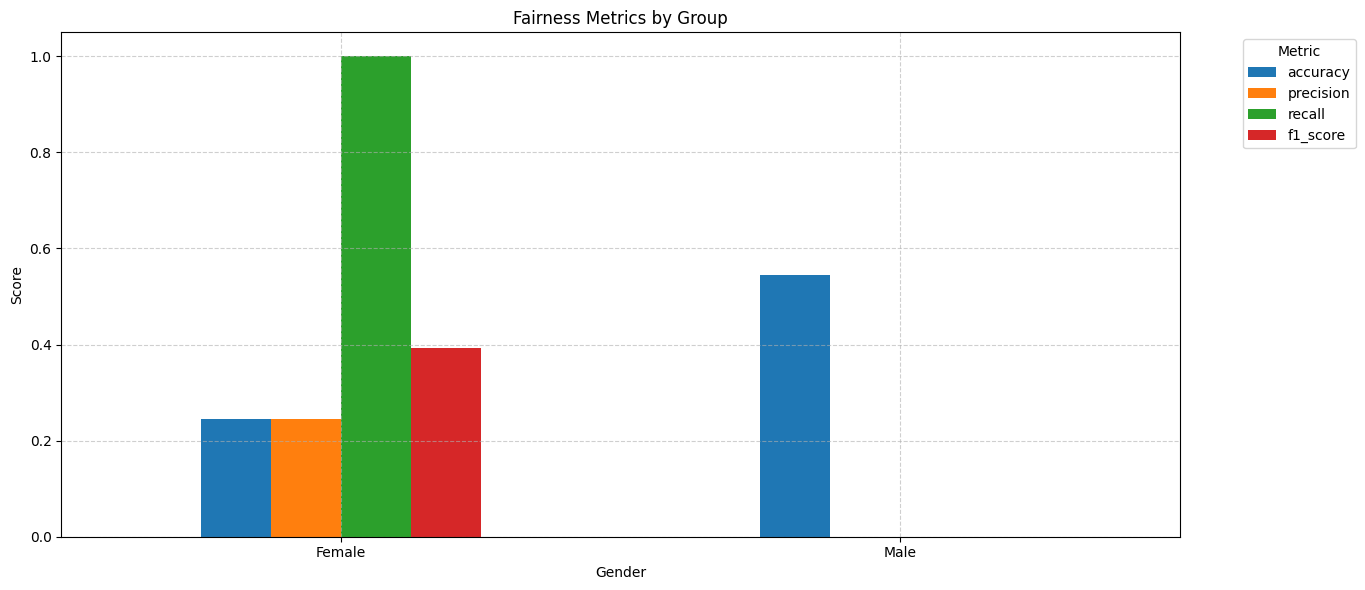

In [15]:
from fairlearn.metrics import MetricFrame, demographic_parity_difference, equalized_odds_difference
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Compute fairness metrics using MetricFrame
metric_frame = MetricFrame(
    metrics={
        'accuracy': accuracy_score,
        'precision': precision_score,
        'recall': recall_score,
        'f1_score': f1_score
    },
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=sensitive_feature
)

# Display overall and group-specific metrics
print("Overall Metrics:")
print(metric_frame.overall)
print("\nMetrics by Group:")
print(metric_frame.by_group)

# Calculate and display fairness differences
dp_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=sensitive_feature)
eo_diff = equalized_odds_difference(y_test, y_pred, sensitive_features=sensitive_feature)

print(f"\nDemographic Parity Difference: {dp_diff:.2f}")
print(f"Equalized Odds Difference: {eo_diff:.2f}")

# Visualize metrics by group using bar plots
ax = metric_frame.by_group.plot(kind='bar', figsize=(12, 6), title="Fairness Metrics by Group")
ax.set_ylabel('Score')
ax.grid(True, linestyle='--', alpha=0.6)  # Adding grid for better readability
ax.set_xticklabels(['Female', 'Male'], rotation=0)  # Assuming 0: Female, 1: Male for clarity in plots
plt.tight_layout()  # Adjust layout to make room for label rotations
plt.legend(title="Metric", bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend out of plot
plt.show()


In [16]:
# Section 11: Fairness-Enhanced Modeling
# --------------------------------------
from fairlearn.reductions import GridSearch, DemographicParity
from sklearn.metrics import accuracy_score

fair_grid = GridSearch(estimator, constraints=DemographicParity(), grid_size=10)
fair_grid.fit(X_train, y_train, sensitive_features=X_train['Gender'])
models = fair_grid.predictors_
best_accuracy = 0
best_model = None
for model in models:
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
print(f"Best Model Accuracy: {best_accuracy:.4f}")



Best Model Accuracy: 0.8825


In [17]:
# Section 12: Adversarial Testing
# -------------------------------
def adversarial_perturbation_test(model, X_test, y_test, sensitive_feature):
    X_perturbed = X_test.copy()
    X_perturbed[sensitive_feature] = 1 - X_perturbed[sensitive_feature]
    y_pred_original = model.predict(X_test)
    y_pred_perturbed = model.predict(X_perturbed)
    accuracy_original = accuracy_score(y_test, y_pred_original)
    accuracy_perturbed = accuracy_score(y_test, y_pred_perturbed)
    prediction_changes = np.mean(y_pred_original != y_pred_perturbed)
    print(f"Accuracy on Original Data: {accuracy_original:.4f}")
    print(f"Accuracy on Perturbed Data: {accuracy_perturbed:.4f}")
    print(f"Percentage of Predictions Changed: {prediction_changes * 100:.2f}%")
    print("Confusion Matrix on Perturbed Data:")
    print(confusion_matrix(y_test, y_pred_perturbed))
    print("Classification Report on Perturbed Data:")
    print(classification_report(y_test, y_pred_perturbed))

adversarial_perturbation_test(model_pipeline, X_test, y_test, 'Gender')

Accuracy on Original Data: 0.8791
Accuracy on Perturbed Data: 0.8870
Percentage of Predictions Changed: 2.60%
Confusion Matrix on Perturbed Data:
[[572  29]
 [ 71 213]]
Classification Report on Perturbed Data:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       601
           1       0.88      0.75      0.81       284

    accuracy                           0.89       885
   macro avg       0.88      0.85      0.86       885
weighted avg       0.89      0.89      0.88       885



In [18]:
import pandas as pd
from aif360.datasets import StandardDataset
from aif360.algorithms.inprocessing import MetaFairClassifier
from sklearn.metrics import accuracy_score, classification_report

# Check for any null values in the dataset
print("Null values before filling:")
print(X_train.isnull().sum(), "\n")
print(X_test.isnull().sum(), "\n")

# Forward fill to handle any missing values, using a more appropriate method to avoid FutureWarning
X_train = X_train.fillna(method='ffill')
X_test = X_test.fillna(method='ffill')

# Check if all missing values are filled
print("Missing values after filling:")
print(X_train.isnull().sum(), "\n")
print(X_test.isnull().sum(), "\n")

# Assuming 'Gender' needs to be a binary encoded column and ensuring the mapping covers all cases:
gender_mapping = {'Male': 1, 'Female': 0}
X_train['Gender'] = X_train['Gender'].map(gender_mapping).fillna(0)  # Default to 0 if not Male/Female
X_test['Gender'] = X_test['Gender'].map(gender_mapping).fillna(0)

# Recreate the StandardDataset objects
aif_train = StandardDataset(
    pd.concat([X_train, y_train], axis=1),
    label_name='Target',
    favorable_classes=[1],
    protected_attribute_names=['Gender'],
    privileged_classes=[[1]]
)

aif_test = StandardDataset(
    pd.concat([X_test, y_test], axis=1),
    label_name='Target',
    favorable_classes=[1],
    protected_attribute_names=['Gender'],
    privileged_classes=[[1]]
)

# Retry fitting the model
try:
    meta_fair_model_adjusted = MetaFairClassifier(tau=0.3, sensitive_attr='Gender')
    meta_fair_model_adjusted.fit(aif_train)
    aif_meta_predictions_adjusted = meta_fair_model_adjusted.predict(aif_test)
    y_pred_meta_fair_adjusted = aif_meta_predictions_adjusted.labels.ravel()
    print("Accuracy on Test Data (Adjusted MetaFairClassifier):", accuracy_score(y_test, y_pred_meta_fair_adjusted))
    print("Classification Report (Adjusted MetaFairClassifier):")
    print(classification_report(y_test, y_pred_meta_fair_adjusted))
except Exception as e:
    print("Error during model fitting:", e)


pip install 'aif360[inFairness]'
<ipython-input-18-f9e6c943976c>:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_train = X_train.fillna(method='ffill')
<ipython-input-18-f9e6c943976c>:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_test = X_test.fillna(method='ffill')


Null values before filling:
Marital status                                    0
Application mode                                  0
Application order                                 0
Course                                            0
Daytime/evening attendance                        0
Previous qualification                            0
Nationality                                       0
Mother's qualification                            0
Father's qualification                            0
Mother's occupation                               0
Father's occupation                               0
Displaced                                         0
Educational special needs                         0
Debtor                                            0
Tuition fees up to date                           0
Gender                                            0
Scholarship holder                                0
Age at enrollment                                 0
International                       

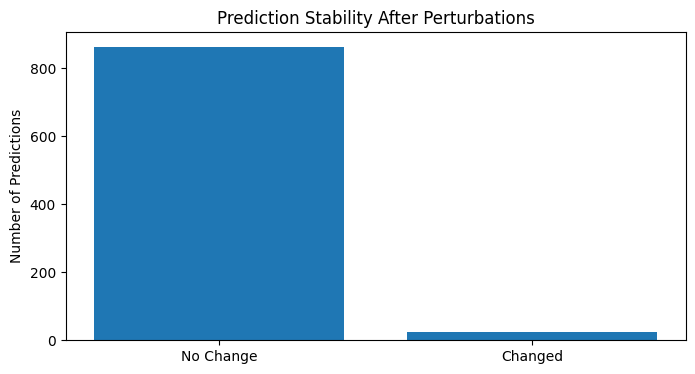

In [19]:
import matplotlib.pyplot as plt

def plot_prediction_stability(y_pred_original, y_pred_perturbed):
    """Visualize the stability of predictions before and after perturbations."""
    changes = y_pred_original != y_pred_perturbed
    plt.figure(figsize=(8, 4))
    plt.bar(['No Change', 'Changed'], [sum(~changes), sum(changes)])
    plt.title('Prediction Stability After Perturbations')
    plt.ylabel('Number of Predictions')
    plt.show()

# Visualize prediction stability for the adversarial test
y_pred_original = model_pipeline.predict(X_test)
y_pred_perturbed = model_pipeline.predict(X_test.assign(Gender=1 - X_test['Gender']))
plot_prediction_stability(y_pred_original, y_pred_perturbed)

In [20]:
# Section 14: Conclusion and Summary
# ----------------------------------
# Summarize the outcomes of the project, reflecting on the learning and potential areas for improvement.

# Example of setting accuracy_adjusted
try:
    meta_fair_model_adjusted = MetaFairClassifier(tau=0.3, sensitive_attr='Gender')
    meta_fair_model_adjusted.fit(aif_train)
    aif_meta_predictions_adjusted = meta_fair_model_adjusted.predict(aif_test)
    y_pred_meta_fair_adjusted = aif_meta_predictions_adjusted.labels.ravel()
    accuracy_adjusted = accuracy_score(y_test, y_pred_meta_fair_adjusted)  # Defining accuracy_adjusted here
    print("Adjusted Fair Model Accuracy:", accuracy_adjusted)
except Exception as e:
    print("Error during model fitting:", e)
    accuracy_adjusted = None  # Ensure variable is defined even if an error occurs


# Section 14: Conclusion and Summary
print("Summary of Model Performances:")
print("Original Model Accuracy:", accuracy_score(y_test, y_pred))
print("Fair Model Accuracy:", accuracy_score(y_test, y_pred_fair))
if 'accuracy_adjusted' in locals() or 'accuracy_adjusted' in globals():
    print("Adjusted Fair Model Accuracy:", accuracy_adjusted)
else:
    print("Adjusted Fair Model Accuracy: Not available due to earlier errors")

# Discuss the impact of fairness interventions
print("\nReflection on Fairness Interventions:")
print("Fairness interventions were applied to adjust the model predictions towards reducing bias.")
print("This included using techniques from the AIF360 toolkit like the Prejudice Remover and MetaFair Classifier.")

# Potential Improvements
print("\nPotential Improvements:")
print("Further experiments could involve more comprehensive grid searches over the hyperparameters of fairness-aware methods.")
print("Additionally, other machine learning algorithms could be explored for potentially better performance and fairness.")

# Closing thoughts
print("\nClosing Thoughts:")
print("This project highlights the importance of considering fairness in predictive modeling, especially for sensitive applications.")
print("Ongoing efforts to refine these models and explore new techniques are crucial for advancing equity in AI.")


Adjusted Fair Model Accuracy: 0.8836158192090395
Summary of Model Performances:
Original Model Accuracy: 0.3536723163841808
Fair Model Accuracy: 0.8598870056497175
Adjusted Fair Model Accuracy: 0.8836158192090395

Reflection on Fairness Interventions:
Fairness interventions were applied to adjust the model predictions towards reducing bias.
This included using techniques from the AIF360 toolkit like the Prejudice Remover and MetaFair Classifier.

Potential Improvements:
Further experiments could involve more comprehensive grid searches over the hyperparameters of fairness-aware methods.
Additionally, other machine learning algorithms could be explored for potentially better performance and fairness.

Closing Thoughts:
This project highlights the importance of considering fairness in predictive modeling, especially for sensitive applications.
Ongoing efforts to refine these models and explore new techniques are crucial for advancing equity in AI.
